In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import heracles
import heracles.dices as dices
from heracles.io import read

# SpaceBorne Vs DICES

- Binned [x]
- Non-Gaussian [x]
- Partial Sky [ ]

In [2]:
nside = 256
lmax = nside
mode = "gaussian"
sims_path = f"{mode}_sims/{mode}_sim_1/"
apply_mask = False
binned = False
nbins = 3

save = True
output_path = f"{mode}_dices/"
if apply_mask:
    output_path = "./masked_"+output_path
else:
    output_path = "./"+output_path

## Maps

In [3]:
data_maps = {}
vis_maps = {}
POS1 = heracles.read_maps(sims_path + "POS_1.fits")
SHE1 = heracles.read_maps(sims_path + "SHE_1.fits")
POS2 = heracles.read_maps(sims_path + "POS_2.fits")
SHE2 = heracles.read_maps(sims_path + "SHE_2.fits")

if apply_mask:
    vmap = hp.read_map("./data/vmap_rotated.fits")
else:
    vmap = POS1[('POS', 1)] / POS1[('POS', 1)]

data_maps[("POS", 1)] = POS1[("POS", 1)]*vmap
data_maps[("POS", 2)] = POS2[("POS", 2)]*vmap
data_maps[("SHE", 1)] = SHE1[("SHE", 1)]*vmap
data_maps[("SHE", 2)] = SHE2[("SHE", 2)]*vmap

vis_maps[("VIS", 1)] = vmap 
vis_maps[("VIS", 2)] = vmap
vis_maps[("WHT", 1)] = vmap
vis_maps[("WHT", 2)] = vmap

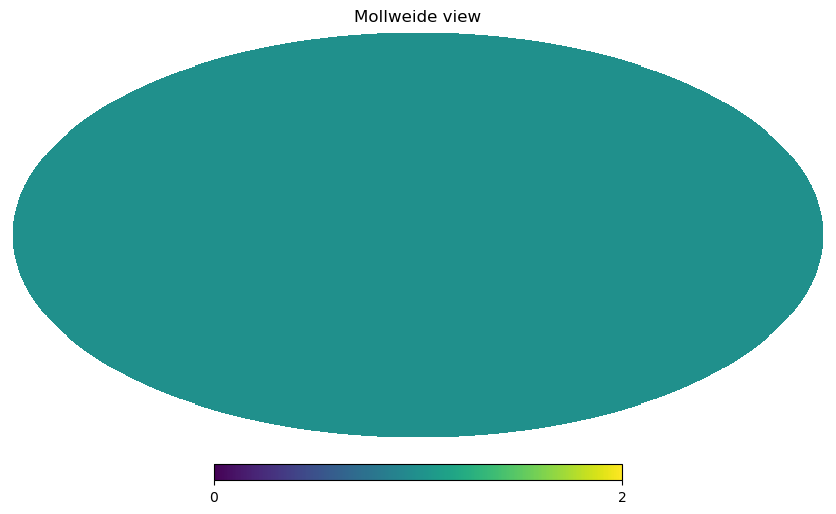

In [4]:
hp.mollview(vmap)

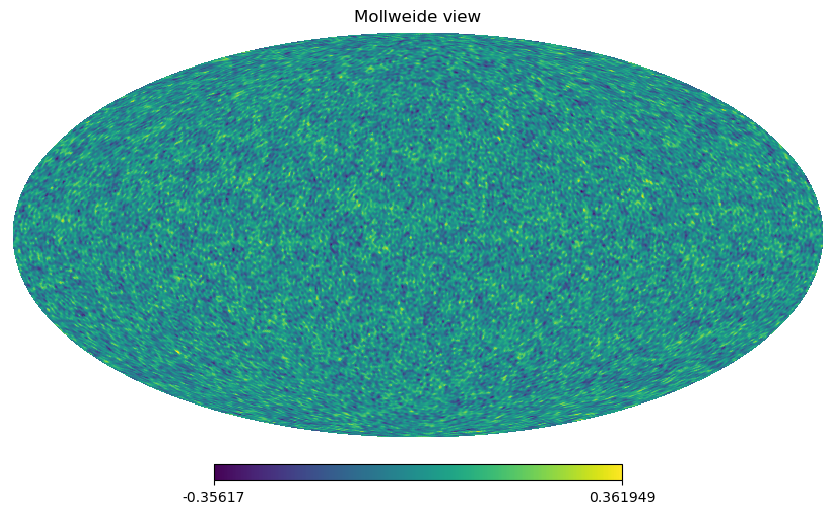

In [5]:
hp.mollview(data_maps[("POS", 1)]) 

In [6]:
jk_maps = {}
Njk = 30
if apply_mask:
    fname = f"./data/masked_jkmap_{Njk}.fits"
else:
    fname = f"./data/jkmap_{Njk}.fits"

print(f"Reading jackknife maps from {fname}")
jkmap = hp.read_map(fname)
for key in list(vis_maps.keys()):
    jk_maps[key] = jkmap


Reading jackknife maps from ./data/jkmap_30.fits


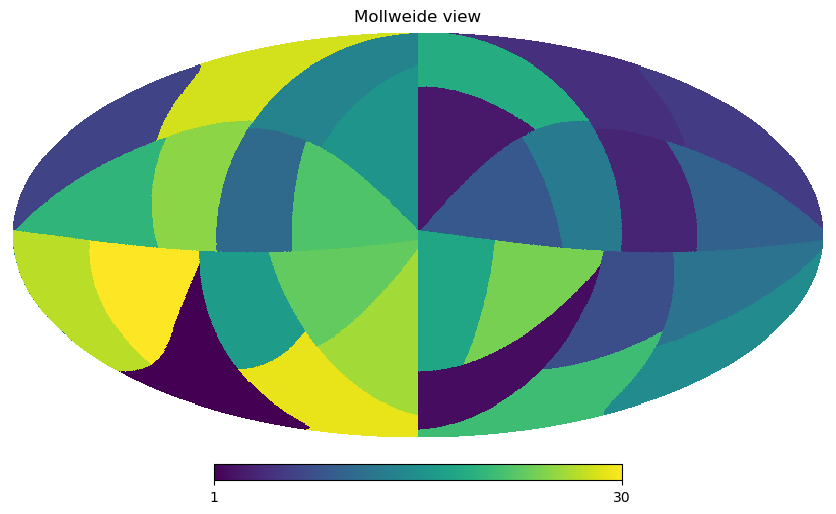

In [7]:
hp.mollview(jk_maps[("VIS", 1)])

## Ensemble Cls

In [8]:
nlbins = 10
ls = np.arange(lmax + 1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

if binned:
    ls = lgrid

In [9]:
theory_cls = heracles.read(f"{mode}_sims/{mode}_sim_1/theory_cls.fits")
if binned:
    for key in list(theory_cls.keys()):
        theory_cls[key] = heracles.binned(theory_cls[key], ledges)

fl = -np.sqrt((ls+2)*(ls+1)*ls*(ls-1))
fl /= np.clip(ls*(ls+1), 1, None)

_theory_cls = {}
_theory_cls[("POS", "POS", 1, 1)] = theory_cls["W1xW1"]
_theory_cls[("POS", "POS", 2, 2)] = theory_cls["W2xW2"]
_theory_cls[("G_E", "G_E", 1, 1)] = theory_cls["W3xW3"].__array__()*fl**2
_theory_cls[("G_E", "G_E", 2, 2)] = theory_cls["W4xW4"].__array__()*fl**2
_theory_cls[("POS", "G_E", 1, 1)] = theory_cls["W1xW3"].__array__()*fl
_theory_cls[("POS", "G_E", 2, 2)] = theory_cls["W2xW4"].__array__()*fl
_theory_cls[("POS", "POS", 1, 2)] = theory_cls["W1xW2"]
_theory_cls[("POS", "G_E", 1, 2)] = theory_cls["W1xW4"].__array__()*fl
_theory_cls[("POS", "G_E", 2, 1)] = theory_cls["W2xW3"].__array__()*fl
_theory_cls[("G_E", "G_E", 1, 2)] = theory_cls["W3xW4"].__array__()*fl**2

_theory_cls[("G_B", "G_B", 1, 1)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("G_B", "G_B", 2, 2)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 1, 1)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 2, 2)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 1, 2)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 2, 1)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("G_B", "G_B", 1, 2)] = np.zeros_like(theory_cls["W3xW3"])

In [10]:
Nbins = 2
__theory_gg = np.zeros((Nbins, Nbins, len(ls)))
__theory_gs = np.zeros((Nbins, Nbins, len(ls)))
__theory_ss = np.zeros((Nbins, Nbins, len(ls)))
for i in range(1, Nbins+1):
    for j in range(i, Nbins+1):
            __theory_gg[i-1, j-1, :] = _theory_cls[("POS", "POS", i, j)]
            __theory_gs[j-1, i-1, :] = _theory_cls[("POS", "POS", i, j)]

            __theory_gs[i-1, j-1, :] = _theory_cls[("POS", "G_E", i, j)]
            __theory_gs[j-1, i-1, :] = _theory_cls[("POS", "G_E", i, j)]

            __theory_ss[i-1, j-1, :] = _theory_cls[("G_E", "G_E", i, j)]
            __theory_ss[j-1, i-1, :] = _theory_cls[("G_E", "G_E", i, j)]

In [11]:
if binned:
    if apply_mask:
        ensemble_cls = heracles.read(f"{mode}_sims/mean_cqs_wmask.fits")
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs_wmask.fits")
    else:
        ensemble_cls = heracles.read(f"{mode}_sims/mean_cqs.fits")
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs.fits")
else:
    if apply_mask:
        ensemble_cls = heracles.read(f"{mode}_sims/mean_cls_wmask.fits")
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls_wmask.fits")
    else:
        ensemble_cls = heracles.read(f"{mode}_sims/mean_cls.fits")
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls.fits") 

## DICES Cls

In [12]:
data_fname = output_path + "cls/cls_nojk.fits"
mask_fname = output_path + "cls/mls_nojk.fits"
cls0 = read(data_fname)
mls0 = read(mask_fname)


In [13]:
cls1 = {}
for jk in range(1, Njk + 1):
    data_fname = output_path + "cls/cls_njk_%i_jkid_%i.fits" % (
        Njk,
        jk,
    )
    cls1[(jk)] = read(data_fname)

In [14]:
if binned:
    cls0 = heracles.binned(cls0, ledges)
    cls1 = heracles.binned(cls1, ledges)

data_fname = output_path + "covs/cov1_njk_%i_binned_%i.fits" % (Njk, binned)
cov1 = read(data_fname)

data_fname = output_path + "covs/target_njk_%i_binned_%i.fits" % (Njk, binned)
target_cov = read(data_fname)

data_fname = output_path + "covs/shrunk_cov1_njk_%i_binned_%i.fits" % (Njk, binned)
scov1 = read(data_fname)

In [15]:
cls2 = {}
for jk in range(1, Njk + 1):
    for jk2 in range(jk + 1, Njk + 1):
        data_fname = (
            output_path
            + "cls/cls_njk_%i_jkid2_%i_%i.fits" % (Njk, jk, jk2)
        )
        cls2[(jk, jk2)] = read(data_fname)

if binned:
    cls2 = heracles.binned(cls2, ledges)

In [16]:
cls0 = dices.Fields2Components(cls0)
for key in list(cls1.keys()):
    cls1[key] = dices.Fields2Components(cls1[key])
for key in list(cls2.keys()):
    cls2[key] = dices.Fields2Components(cls2[key]) #cls1[key] 

In [17]:
_cls1 = {}
for key in list(cls1[(1)].keys()):
    _cls = []
    for i in range(1, Njk+1):
        cl = cls1[(i)][key]
        _cls.append(cl)
    _cls1[key] = np.array(_cls)

_cls2 = {}
for key in list(cls2[(1, 2)].keys()):
    _cls = []
    for i in range(1, Njk+1):
        for j in range(i+1, Njk+1):
            cl = cls2[(i, j)][key]
            _cls.append(cl)
    _cls2[key] = np.array(_cls)

#_cls2 = _cls1

cls1_m = {}
cls1_s = {}
cls2_m = {}
cls2_s = {}
for key in list(_cls1.keys()):
    cls1_m[key] = np.mean(_cls1[key], axis=0)
    cls1_s[key] = np.std(_cls1[key], axis=0)
    cls2_m[key] = np.mean(_cls2[key], axis=0)
    cls2_s[key] = np.std(_cls2[key], axis=0)

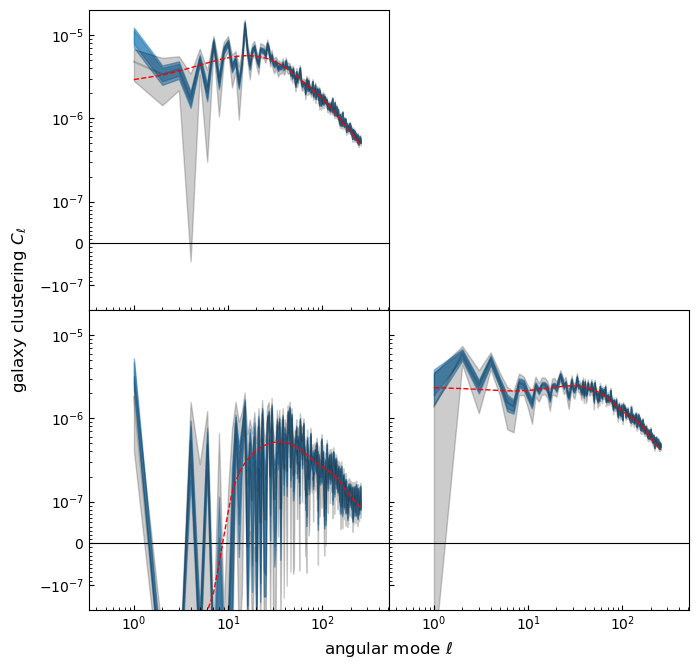

In [18]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        _vcl = _theory_cls[key][1:]
        _cl = cls0[key][1:]
        cl1m = cls1_m[key][1:]
        cl1s = cls1_s[key][1:]
        cl2m = cls2_m[key][1:]
        cl2s = cls2_s[key][1:]
        err = np.sqrt(np.diag(ensemble_cov[key]))[1:]
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl1m-cl1s, cl1m+cl1s, color="C0", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl2m-cl2s, cl2m+cl2s, color="C0", alpha=0.5
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _cl, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], _cl-err, _cl+err, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _vcl, "r--", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-2e-7, 2e-5)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

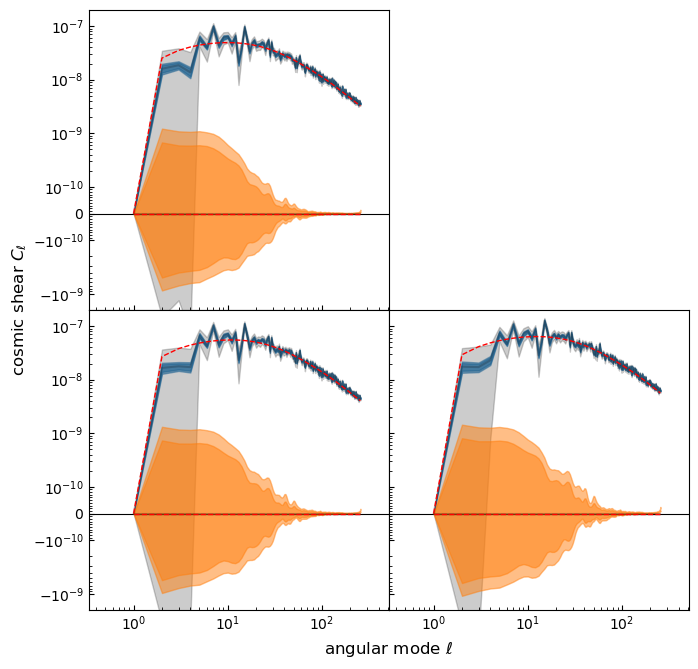

In [19]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("G_E", "G_E", i, j)
        _vcl = _theory_cls[key][1:]
        _cl = cls0[key][1:]
        cl1m = cls1_m[key][1:]
        cl1s = cls1_s[key][1:]
        cl2m = cls2_m[key][1:]
        cl2s = cls2_s[key][1:]
        err = np.sqrt(np.diag(ensemble_cov[key]))[1:]
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl1m-cl1s, cl1m+cl1s, color="C0", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl2m-cl2s, cl2m+cl2s, color="C0", alpha=0.5
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _cl, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], _cl-err, _cl+err, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _vcl, "r--", lw=1.0, zorder=4.0
        )

        key = ("G_B", "G_B", i, j)
        _vcl = _theory_cls[key][1:]
        _cl = cls0[key][1:]
        cl1m = cls1_m[key][1:]
        cl1s = cls1_s[key][1:]
        cl2m = cls2_m[key][1:]
        cl2s = cls2_s[key][1:]
        err = np.sqrt(np.diag(ensemble_cov[key]))[1:]
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl1m-cl1s, cl1m+cl1s, color="C1", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl2m-cl2s, cl2m+cl2s, color="C1", alpha=0.5
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _cl, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], _cl-err, _cl+err, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _vcl, "r--", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-2e-9, 2e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

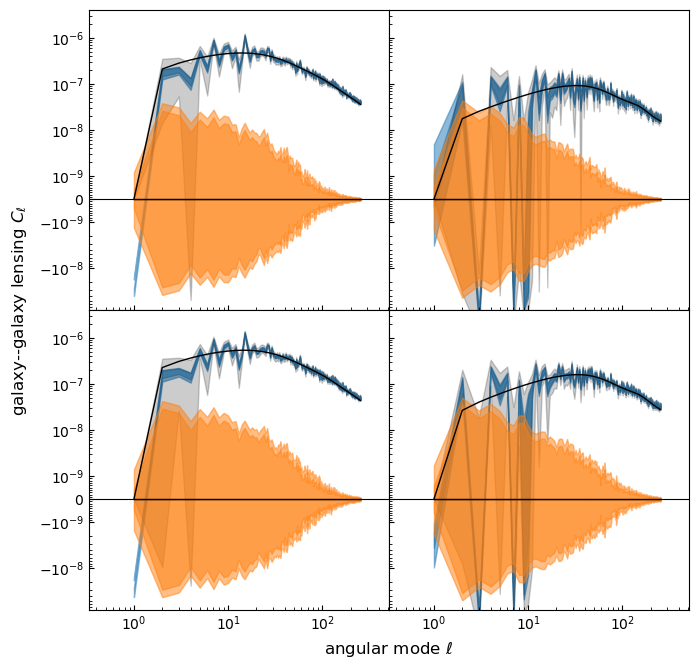

In [20]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "G_E", i, j)
        _vcl = -_theory_cls[key][1:]
        _cl = -cls0[key][1:]
        cl1m = -cls1_m[key][1:]
        cl1s = cls1_s[key][1:]
        cl2m = -cls2_m[key][1:]
        cl2s = cls2_s[key][1:]
        err = np.sqrt(np.diag(ensemble_cov[key]))[1:]
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl1m-cl1s, cl1m+cl1s, color="C0", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl2m-cl2s, cl2m+cl2s, color="C0", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], _cl-err, _cl+err, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _vcl, c="k", lw=1.0, zorder=4.0
        )

        key = ("POS", "G_B", i, j)
        _vcl = _theory_cls[key][1:]
        _cl = cls0[key][1:]
        cl1m = cls1_m[key][1:]
        cl1s = cls1_s[key][1:]
        cl2m = cls2_m[key][1:]
        cl2s = cls2_s[key][1:]
        err = np.sqrt(np.diag(ensemble_cov[key]))[1:]
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl1m-cl1s, cl1m+cl1s, color="C1", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], cl2m-cl2s, cl2m+cl2s, color="C1", alpha=0.5
        )
        ax[j - 1, i - 1].fill_between(
            ls[1:], _cl-err, _cl+err, color="k", alpha=0.2
        )
        ax[j - 1, i - 1].plot(
            ls[1:], _vcl, c="k", lw=1.0, zorder=4.0
        )
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_yscale(
    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-8e-8, 4e-6)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()

## Comparison

In [21]:
cov1 = read(output_path + "covs/cov1_njk_%i_binned_%i.fits" % (Njk, binned))
cov2 = read(output_path + "covs/cov2_njk_%i_binned_%i.fits" % (Njk, binned))
dices_cov = read(output_path + "covs/dices_njk_%i_binned_%i.fits" % (Njk, binned))
sb_cov = np.load("./data/sb_cov_dict.npz", allow_pickle=True)["arr_0"].item()

In [22]:
dices_cov[("POS", "POS", "POS", "POS", 1, 1, 1, 1)].__array__().shape

(257, 257)

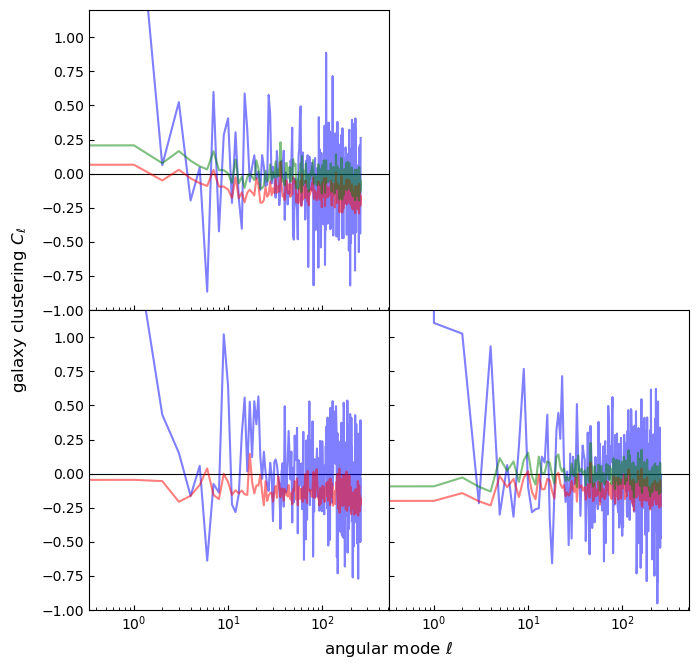

In [23]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        kk = ("POS", "POS",  "POS", "POS", i, j, i, j)
        sb_kk = ("POS", "POS",  "POS", "POS", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-1, 1.2)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_133771/90728022.py:17: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_133771/90728022.py:17: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_133771/90728022.py:20: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')
/tmp/ipykernel_133771/90728022.py:38: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g--', alpha=0.5, label='Gaussian')


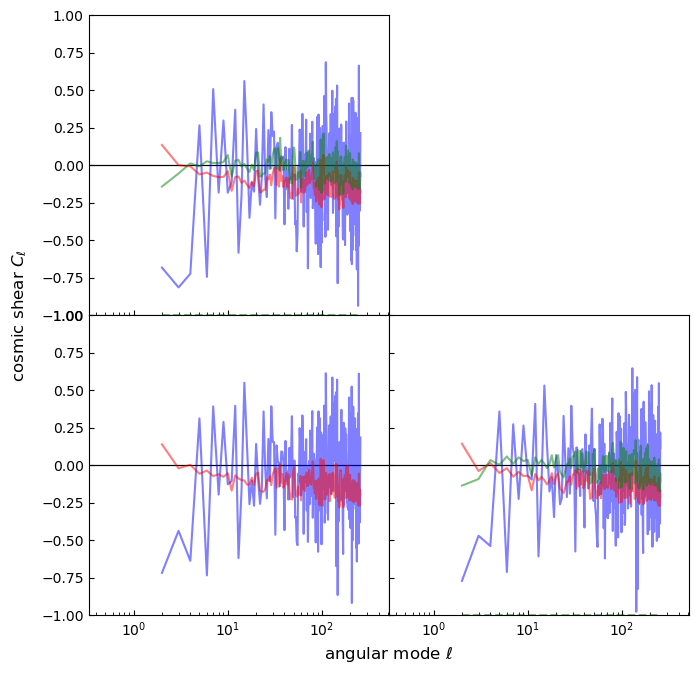

In [24]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("G_E", "G_E", i, j)
        kk = ("G_E", "G_E",  "G_E", "G_E", i, j, i, j)
        sb_kk = ("G_E", "G_E",  "G_E", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

        key = ("G_B", "G_B", i, j)
        kk = ("G_B", "G_B",  "G_B", "G_B", i, j, i, j)
        sb_kk = ("G_B", "G_B",  "G_B", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        #sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b--', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g--', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-1, 1)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_133771/1897291075.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
/tmp/ipykernel_133771/1897291075.py:15: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_133771/1897291075.py:15: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_133771/1897291075.py:18: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')
/tmp/ipykernel_133771/1897291075.py:32: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b--', alpha=0.5, label='DICES')
/tmp/ipykernel_133771/1897291075.py:36: RuntimeWarning: invalid value encountered in divide
  ax[j - 

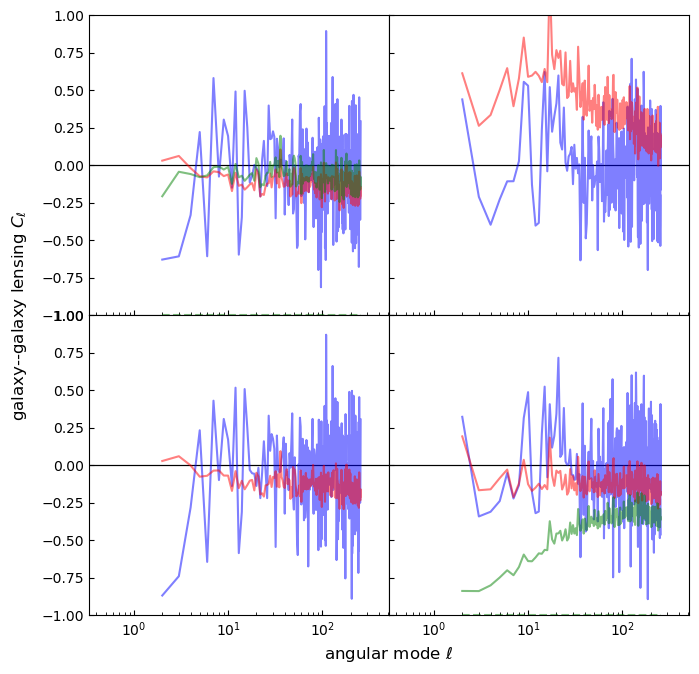

In [25]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "G_E", i, j)
        kk = ("POS", "G_E",  "POS", "G_E", i, j, i, j)
        sb_kk = ("POS", "G_E",  "POS", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

        key = ("POS", "G_B", i, j)
        kk = ("POS", "G_B",  "POS", "G_B", i, j, i, j)
        sb_kk = ("POS", "G_B",  "POS", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        #sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b--', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g--', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-1, 1)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()